In [2]:
#Load libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time
import warnings
from bs4 import BeautifulSoup
from datetime import timedelta
from sklearn.cluster import KMeans
from urllib.error import HTTPError

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [14]:
#Create dictionary with ticker symbols and economic sector per listing
stock_dict = {'EGAD':'Agricultural', 'KUKZ':'Agricultural', 'KAPC':'Agricultural', 
              'CGEN': 'Automobiles and Accessories',
               'LIMT':'Agricultural', 'SASN':'Agricultural', 'WTK':'Agricultural', 
               'ABSA':'Banking', 'BKG':'Banking', 'COOP':'Banking', 'DTK':'Banking', 
               'EQTY':'Banking', 'HFCK':'Banking', 'IMH':'Banking', 'KCB':'Banking', 
               'NBK':'Banking', 'NCBA':'Banking', 'SBIC':'Banking', 'SCBK':'Banking',
               'DCON':'Commercial and Services', 'EVRD':'Commercial and Services', 
               'XPRS':'Commercial and Services','HBE':'Commercial and Services', 
               'KQ':'Commercial and Services', 'LKL':'Commercial and Services',
               'NBV':'Commercial and Services', 'NMG':'Commercial and Services', 
               'SMER':'Commercial and Services', 'SGL':'Commercial and Services', 
               'TPSE':'Commercial and Services', 'UCHM':'Commercial and Services', 
               'SCAN':'Commercial and Services', 'ARM':'Construction and Allied', 
               'BAMB':'Construction and Allied', 'CRWN':'Construction and Allied', 
               'CABL':'Construction and Allied', 'PORT':'Construction and Allied',
               'KEGN':'Energy and Petroleum', 'KPLC-P4':'Energy and Petroleum', 
               'KPLC-P7':'Energy and Petroleum', 'KPLC':'Energy and Petroleum', 
               'TOTL':'Energy and Petroleum', 'UMME':'Energy and Petroleum',
               'BRIT':'Insurance', 'CIC':'Insurance', 'JUB':'Insurance', 'KNRE':'Insurance', 
               'LBTY':'Insurance', 'SLAM':'Insurance', 'CTUM':'Investment', 'HAFR':'Investment', 
               'KURV':'Investment', 'OCH':'Investment', 'TCL':'Investment', 'NSE':'Investment Services',
               'BOC':'Manufacturing and Allied', 'BAT':'Manufacturing and Allied', 'CARB':'Manufacturing and Allied',
               'EABL':'Manufacturing and Allied', 'FTGH':'Manufacturing and Allied', 'ORCH':'Manufacturing and Allied', 
               'MSC':'Manufacturing and Allied', 'UNGA':'Manufacturing and Allied', 'SCOM':'Telecommunication and Technology',
               'FAHR':'Real Estate Investment Trusts', 'GLD':'Exchange Traded Funds'   
              }

#Extract tickers from dictionary keys and save them into a list
tickers = list(stock_dict.keys())

In [3]:
#The target website requires login 
#Generate cookies and headers through cURL from the website
cookies = {"cookies"}

headers = {"headers"}

In [4]:
#Define the end date (last date of the query); the previous working day
end_date = datetime.datetime.now() - datetime.timedelta(days=1)

#Define start date of the query - 10 years ago!
start_date = end_date - datetime.timedelta(days=365*10)

#Create a delta object - range of the query
delta = end_date - start_date

mega_data = []
errors = []
# Loop through the delta object 
for i in range(delta.days):
    try:
        #Date to append to end of url
        date = start_date + timedelta(days=i)
        date = date.strftime('%Y%m%d')
        
        #Relevant url
        url = f'https://live.mystocks.co.ke/price_list/{date}'
        
        #Response using cookies and headers
        response = requests.get(url, cookies=cookies, headers=headers)
        
        #Use Pandas read_html to read the response
        data = pd.read_html(response.text)
        
        #The relevant table is in the third position
        data = data[2]
        
        #The table has multi index headers - drop them
        data.columns = data.columns.droplevel(0)
        
        #Loop through the rows and indexes and drop rows that do not contain ticker symbols (mostly NaNs)
        for index, row in data.iterrows():
            if (row.str.contains(str(tickers)).all()):
                data = data.drop(index)
                #Replace - in data with zero
                data = data.replace(to_replace = '-', value='0')
            else:
                pass
        mega_data.append(data)
        time.sleep(5)
    #Exception to handle HTTP error which may occur when no data is found for a date
    except HTTPError as err:
        errors.append(err)

#Concatenate all dataframes in list of multiple dataframes to one dataframe using similar index
mega_df_ = pd.concat([df.set_index('CODE') for df in mega_data], axis=0, ignore_index=False)
mega_df_.to_csv(f'/users/solomonmuthui/Desktop/stocks_df_all_{start_date}-{end_date}.csv')
mega_df_

,NAME,Low,High,Low,High,Price,Previous,Change,Change,Change,Volume,Adjusted Price
CODE,,,,,,,,,,,,
EGAD,Eaagads Ltd,11.40,14.00,51.00,53.00,51.50,52.00,(0.50),0.96%,▼,5100,25.75
KUKZ,Kakuzi Plc,365.00,450.00,74.00,74.00,74.00,75.00,(1.00),1.33%,▼,20000,0
KAPC,Kapchorua Tea Kenya Plc,80.00,110.00,130.00,130.00,130.00,130.00,0,0,NaN,0,65.00
LIMT,Limuru Tea Plc,285.00,510.00,450.00,450.00,450.00,450.00,0,0,NaN,0,225.00
SASN,Sasini Plc,17.90,24.00,11.20,11.80,11.25,11.30,(0.05),0.44%,▼,15800,0
...,...,...,...,...,...,...,...,...,...,...,...,...
MSC,Mumias Sugar Company Ltd,0.27,0.27,0.27,0.27,0.27,0.27,0,0,NaN,0,0
UNGA,Unga Group Ltd,27.00,36.40,30.50,31.00,30.70,31.00,(0.30),0.97%,▼,4500,0
SCOM,Safaricom Plc,23.00,44.00,29.70,30.00,29.90,29.85,0.05,0.17%,▲,3071200,0


More than 230k worth of data

In [5]:
errors

[]

In [7]:
#Read file from dir
warnings.filterwarnings('ignore')
mega_df_ = pd.read_csv('/users/solomonmuthui/Desktop/Py/stocks_df_all_2012-09-11-2022-09-09.csv', index_col=0)
mega_df = mega_df_[['Price', 'Previous']]
mega_df['Price'] = mega_df['Price'].str.replace(',', '')
mega_df['Price'] = mega_df['Price'].str.replace('\(adsbygoogle\=window.adsbygoogle\|\|\[\]\).push\(\{\}\)', '')
mega_df = mega_df.replace(to_replace='', value=np.nan)
mega_df['Previous'] = mega_df['Previous'].str.replace(',', '')
mega_df = mega_df.dropna(axis=0, how='any')

#Convert dataframe to float
mega_df = mega_df.astype('float64')

#Insert new column from two existing columns
mega_df['Returns'] = mega_df['Price']/mega_df['Previous']
mega_df = mega_df.dropna(axis=0, how='any')

#Transform said column to logarithm form
mega_df['Returns'] = np.log(mega_df['Returns'])

# #Save dataframe used for analysis to CSV
# mega_df.to_csv(f'/users/solomonmuthui/Desktop/stocks_df_analysis_{start_date}-{end_date}.csv')
mega_df

,Price,Previous,Returns
CODE,,,
EGAD,51.50,52.00,-0.009662
KUKZ,74.00,75.00,-0.013423
KAPC,130.00,130.00,0.000000
LIMT,450.00,450.00,0.000000
SASN,11.25,11.30,-0.004435
...,...,...,...
MSC,0.27,0.27,0.000000
UNGA,30.70,31.00,-0.009725
SCOM,29.90,29.85,0.001674


In [8]:
#Compute mean and standard deviation of returns 
ret_mean = mega_df.groupby('CODE')['Returns'].mean()
ret_std = mega_df.groupby('CODE')['Returns'].std()

#Concate mean and standard deviation into a dataframe
std_mean_returns = pd.concat([ret_mean, ret_std], axis=1)
std_mean_returns.columns = ['Returns', 'Std. Dev']
std_mean_returns = std_mean_returns.dropna(axis=0)
std_mean_returns

,Returns,Std. Dev
CODE,,
ABSA,0.000028,0.014670
ARM,-0.001447,0.050705
BAMB,-0.000433,0.020009
BAT,0.000409,0.021276
BOC,0.000001,0.025733
...,...,...
TPSE,-0.000764,0.028510
UCHM,-0.001381,0.036364
UNGA,0.000455,0.029104


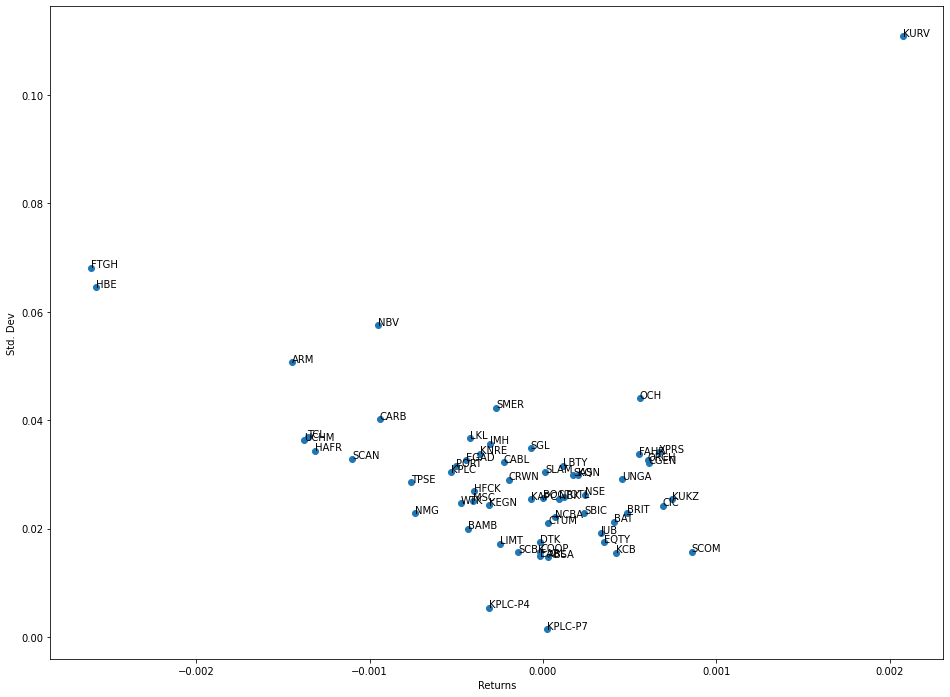

In [9]:
#Plot the ticker symbols - returns against standard deviation
def plot_returns_std_dev(df, x, y):
    """
    Function to plot a scatter of mean returns of a stock (x) against 
    their standard deviations (y).
    Returns scatterplot that includes the ticker symbols text and position.
    """
    fig, ax = plt.subplots(figsize=(16,12))
    scatter = ax.scatter(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    #Loop through all rows and insert the index (ticker symbol) in the correct position
    for index, row in df.iterrows():
        plt.text(row[x], row[y], index)

plot_returns_std_dev(std_mean_returns, 'Returns', 'Std. Dev')

In [10]:
#Insert new column that calculates the z_scores of the returns
std_mean_returns['z_score'] = (std_mean_returns['Returns'] - std_mean_returns['Returns'].mean())/std_mean_returns['Returns'].std()

#Redefine the dataframe to only include inputs whose z_scores are -3<x<3
std_mean_returns = std_mean_returns[(std_mean_returns['z_score']>-3) | (std_mean_returns['z_score']<3)]
std_mean_returns.sort_values('Returns', ascending=False)

,Returns,Std. Dev,z_score
CODE,,,
KURV,0.002075,0.110885,2.938263
SCOM,0.000858,0.015750,1.343629
KUKZ,0.000747,0.025397,1.197672
CIC,0.000690,0.024227,1.123071
XPRS,0.000668,0.034075,1.094339
...,...,...,...
TCL,-0.001358,0.036851,-1.562165
UCHM,-0.001381,0.036364,-1.591521
ARM,-0.001447,0.050705,-1.678635


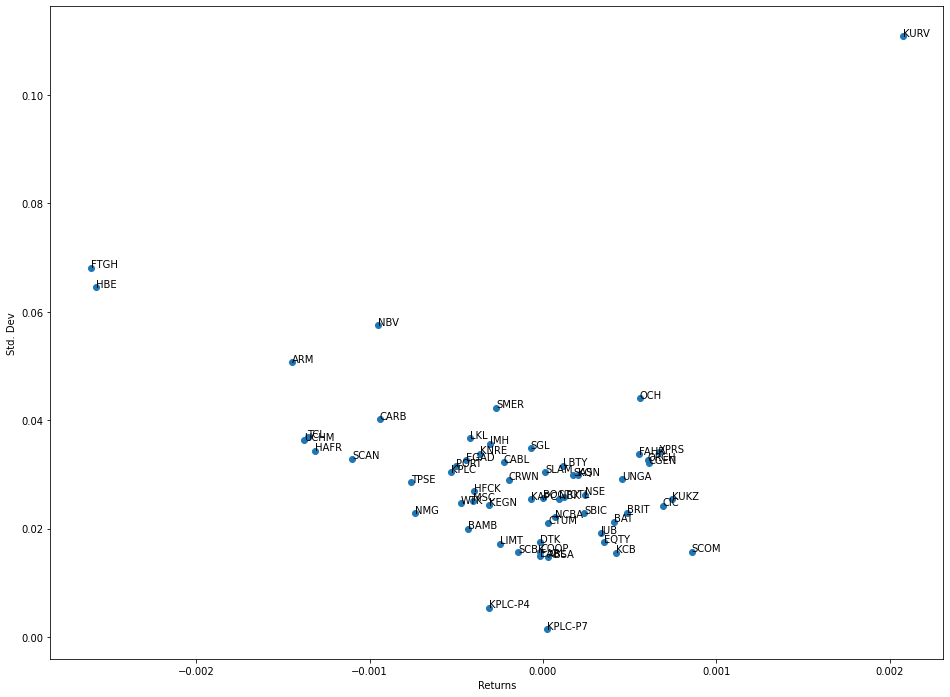

In [110]:
#Plot again to see which tickers have been removed
plot_returns_std_dev(std_mean_returns, 'Returns', 'Std. Dev')

No outliers in the dataset!

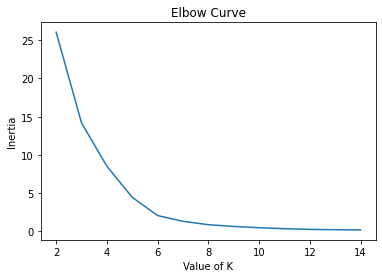

In [11]:
#Define the X variable
X = std_mean_returns.values
sum_sq_error = []

#Loop through possible values of k for the KMeans model
for k in range(2,15): 
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(X)
    #Append the model's inertial to sum_squared_error list
    sum_sq_error.append(model.inertia_)

#Plot the inertiae against the possible values of k
plt.plot(range(2,15), sum_sq_error)
plt.title('Elbow Curve')
plt.xlabel('Value of K')
plt.ylabel('Inertia')
plt.show()

Choose 6 clusters as per the elbow joint

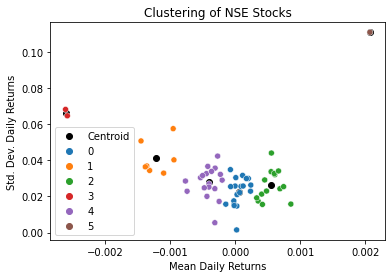

In [12]:
#Initialize a KMeans model with 6 clusters - per the elbow curve above - and fit to X
model = KMeans(n_clusters = 6, random_state=42).fit(X)

#Predict the clusters for X or labels
y_kmeans = model.fit_predict(X)

#Plot the cluster values and their centroids 
centroids = model.cluster_centers_

#The centroids...
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='black', label='Centroid')

#The X variable...
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_kmeans, data=X, palette='tab10')
plt.xlabel('Mean Daily Returns')
plt.ylabel('Std. Dev. Daily Returns')
plt.title('Clustering of NSE Stocks')
plt.show()

In [17]:
#Create dataframe with ticker symbols only
ticker_co = pd.DataFrame(std_mean_returns.index)

#Create dataframe with cluster label
labels = pd.DataFrame(model.labels_)

#Concatenate the two dataframes
cluster_df = pd.concat([ticker_co, labels], axis=1)

#Define columns
cluster_df.columns = ['Ticker', 'Cluster']

#Sort by cluster
cluster_df = cluster_df.sort_values('Cluster')

#Create a new column that maps ticker symbol to a dictionary containing the ticker's economic sector
cluster_df['Sector'] = cluster_df['Ticker'].map(stock_dict)

#Save dataframe to CSV
cluster_df.to_csv('/users/solomonmuthui/desktop/Py/cluster_df_10_years.csv')
cluster_df

,Ticker,Cluster,Sector
0,ABSA,0,Banking
55,TOTL,0,Energy and Petroleum
52,SLAM,0,Insurance
51,SGL,0,Commercial and Services
49,SCBK,0,Banking
...,...,...,...
22,IMH,4,Banking
21,HFCK,4,Banking
45,PORT,4,Construction and Allied
37,MSC,4,Manufacturing and Allied
